In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.integrate import quad
import pylandau
from util.cer_util import CER
import util.theory as theory

## Analytic Likelihood.
The likelihood function will have the form:
$$\mathscr{L}_i=f\left(x_i; \frac{\Delta_p}{dx}(E, \Delta p_i), \eta(E, \Delta p_i), \sigma(E, \Delta p_i)\right)$$
where $\Delta p=\frac{0.3\,\text{cm}}{\cos(\gamma)}$ is the pitch, $E$ is the true energy, and $\frac{\Delta_p}{dx}, \eta, \sigma$ are the MPV, Landau FWHM, and Gaussian width of the Langau. We expect that the $E$ should also be subscripted $i$ as the true energy changes with each energy loss but for now we continue to approximate the true energy as constant throughout the muon track:
$$-\ln(\mathscr{L}(E))=-\sum_i \ln\left(f\left[x_i; \frac{\Delta_p}{dx}(E, \Delta p_i), \eta(E, \Delta p_i), \sigma(E, \Delta p_i)\right]\right)$$
To resolve the discrepancy in the mpv values I saw before due to calibration error for the non-stopping muon energy loss mpvs, I will fit a 'calibration constant' to the theoretical equation that will hopefully resolve the issue. This is obviously not physically motivated, but just an attempt to get this method to work for our purposes.

First I need to do some interpolation on the $\eta$ and mpv parameters, $\sigma$ will be held fixed. I will use only lowpitch data, so pitches will not be taken into account.

In [2]:
fitdf = pd.read_csv(r'./data/fit_data/narrow_lowpitch_fixedsig_fit_data.csv')
fixed_sig = fitdf.sigma.unique()[0]

[1.23352855 1.76729723 2.30919105 2.85794245 3.4559895  4.13330447
 4.94515195 6.03208694 7.44654886 9.10307099]


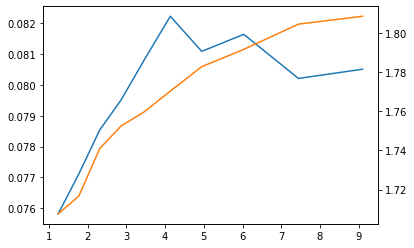

In [3]:
e_bin_centers = 10**((np.log10(fitdf.e_max) + np.log10(fitdf.e_min))/2).to_numpy()
print(e_bin_centers)
plt.plot(e_bin_centers, fitdf.eta)
plt.twinx().plot(e_bin_centers, fitdf.mpv, c='tab:orange')
# plt.xscale('log')

In [4]:
def loginterp(x, y, kind='linear'):
    return lambda z: np.power(10, interpolate.interp1d(np.log10(x), np.log10(y), kind)(np.log10(z)))

[0.68988275]


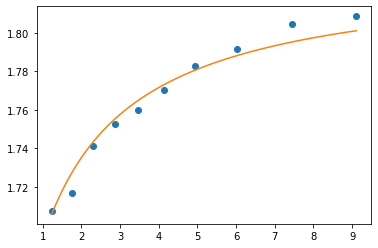

In [5]:
mpvfit = lambda ke, x: theory.dpdx(ke*1000, x, theory.Mmu)
popt, pcov = curve_fit(mpvfit, e_bin_centers, fitdf.mpv, p0=2.5, bounds=(0,5))
print(popt)
x = np.linspace(e_bin_centers[0], e_bin_centers[-1], 1000)

plt.plot(e_bin_centers, fitdf.mpv, ls='', marker='o')
plt.plot(x, [ mpvfit(y, *popt) for y in x ])

In [6]:
# Define the interpolation functions that we will use to evaluate mpv and eta
eta_interp = interpolate.interp1d(e_bin_centers, fitdf.eta, kind='linear')
mpv_interp = interpolate.interp1d(e_bin_centers, fitdf.mpv, kind='linear')

log_eta_interp = loginterp(e_bin_centers, fitdf.eta, kind='linear')
log_mpv_interp = loginterp(e_bin_centers, fitdf.mpv, kind='linear')

mpv_fit = lambda E: mpvfit(E, *popt)
sig_func = lambda sig: fixed_sig 

In [7]:
e_lims = (e_bin_centers[0], e_bin_centers[-1])

In [8]:
cer = CER(pitch_lims=(0.3, 0.4), angle_given=False, e_lims=e_lims)
cer.load_muons()

Loading Data...
Loaded!
Slimming...
Will remove 9611 particles
There are 173 muons left to analyze


In [9]:
def negloglikelihood(E, dedxs, mpvfunc, etafunc, sigfunc):
    mpv = np.float64(mpvfunc(E))
    eta = np.float64(etafunc(E))
    sig = np.float64(sigfunc(E))
    N = dedxs.shape[0]
    negloglike = -1 * np.sum([ np.log(eta*pylandau.get_langau_pdf(dedx, mpv, eta, sig)) for dedx in dedxs.astype('float64') ])
    return negloglike

In [42]:
mu_idx = 17
dedxs = cer.muons.dedx_y.loc[mu_idx].to_numpy()
res = minimize(negloglikelihood, x0=[5], args=(dedxs, mpv_interp, eta_interp, sig_func), method=None, bounds=[e_lims])
print("Success:", res.success)
print("Result:", res.x[0])
print("True:", cer.muons.backtracked_e.loc[mu_idx])

Success: True
Result: 6.032086892094069
True: 2.6934617


Text(0.5, 0, 'Kinetic Energy (GeV)')

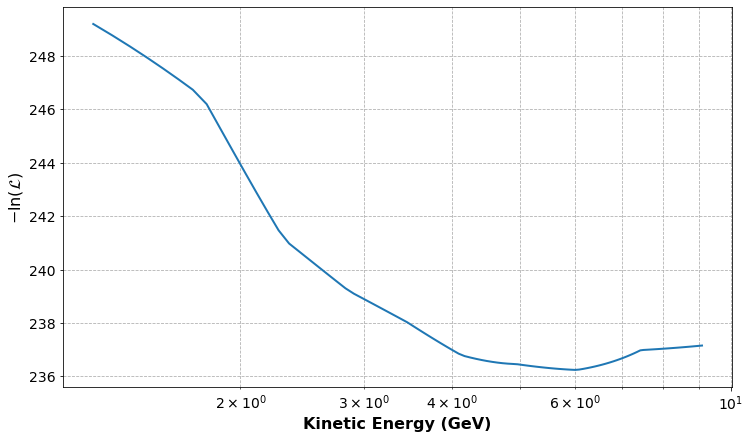

In [43]:
plt.style.use(r'./stylesheets/eloss.mplstyle')
x = np.linspace(e_bin_centers[0], e_bin_centers[-1], 100)
plt.plot(x, [ negloglikelihood(_, dedxs, mpv_interp, eta_interp, sig_func) for _ in x ], ls='-')
plt.xscale('log')
plt.ylabel(r'$-\ln(\mathcal{L})$')
plt.xlabel(r'Kinetic Energy (GeV)')

### Run on all the muons in the smaller dataset

In [93]:
truth = []
reconstructed = []
for i in cer.muons.index:
    dedxs = cer.muons.dedx_y.loc[i].to_numpy()
    res = minimize(negloglikelihood, x0=[5], args=(dedxs, mpv_fit, eta_interp, sig_func), method=None, bounds=[e_lims])
    truth.append(cer.muons.backtracked_e.loc[i])
    reconstructed.append(res.x)
    if not res.success:
        print("Failed minimization at index", i)

Failed minimization at index 167


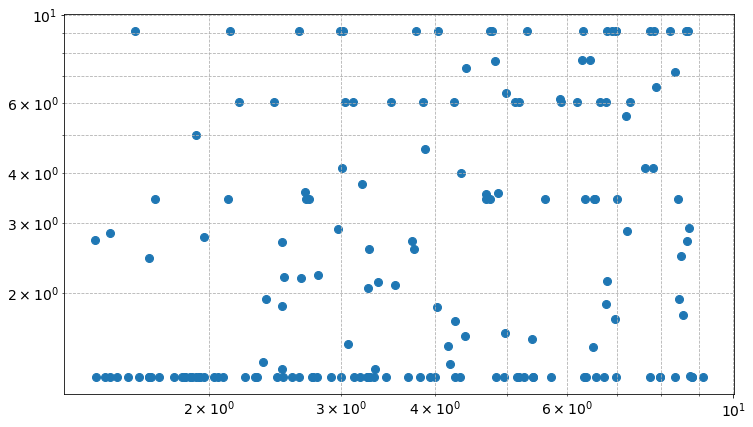

In [137]:
plt.scatter(truth, reconstructed)
# plt.ylim(e_bin_centers[0]+0.025, e_bin_centers[-1]-0.15)
plt.xscale('log')
plt.yscale('log')